### Objective of the project is:
This project aims to analyze and forecast energy consumption to:
- Identify trends and patterns in energy usage.
- Predict future energy consumption to optimize resource allocation.
- Segment energy consumption patterns for better cost management.

### Key Questions I raised are:
- What are the trends in energy consumption over time?
- How can energy consumption be forecasted accurately?
- How can energy usage patterns be segmented to identify similar consumption behaviors?

### Expected Outcome of the project is:
- An energy consumption forecasting model.
- Clustering insights on identifying the pattern of consumption.
- Business recommendations based on findings.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import silhouette_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import math

##Data Understanding
### Dataset Summary:
- **Data Source**: NYC Energy Consumption Dataset (2010–2023) from nyc.gov
- **Size of dataset**: It has over 125,000 observations with 30 columns.
- **Key Features of the dataset**:
  - `Consumption (KWH)`: Energy consumption.
  - `Current Charges`: Charges associated with consumption.
  - `Charge_per_KWH`: Cost per unit of energy (engineered feature).

### Insights:
- Trends in energy consumption vary by borough and location.
- Missing values were identified in certain columns and are handled appropriately.


In [ ]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#loading the dataset
file_path='/content/drive/My Drive/Data_602/Electric_Consumptions_And_Costs__2010_-_Feb_2023.csv'
data=pd.read_csv(file_path)
print(f"Dataset size: {data.shape}")
print(data.head())

Dataset size: (125980, 30)
  Development Name Borough Account Name Location Meter AMR   Meter Scope  \
0            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
1            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
2            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
3            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
4            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   

   TDS #    EDP  RC Code Funding Source  ...   Rate Class Bill Analyzed  \
0  118.0  248.0  B011800        FEDERAL  ...  GOV/NYC/068           Yes   
1  118.0  248.0  B011800        FEDERAL  ...  GOV/NYC/068           Yes   
2  118.0  248.0  B011800        FEDERAL  ...  GOV/NYC/068           Yes   
3  118.0  248.0  B011800        FEDERAL  ...  GOV/NYC/068           Yes   
4  118.0  248.0  B011800        FEDERAL  ...  GOV/NYC/068           Yes   

   Consumption (KWH)  KWH Charges Consumption (KW) KW Charges  Ot

<ipython-input-33-b9ac03c78db2>:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(file_path)


##Data Preparation
### Steps to perform in data preparation are:
1. **Handling Missing Values**:
   - Numerical columns are imputed with mean where as categorical values are imputed with mode.
2. **Outlier Detection and Handling**:
   - Applied the IQR method to identify and cap extreme values.
3. **Feature Engineering**:
   - Created `Charge_per_KWH`, `Rolling_Consumption`, and `Consumption_Ratio` features.
4. **Scaling**:
   - Applied standard scaling to numerical columns.


In [ ]:
#Handle missing values for numerical columns and categorical columns
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    data[col]=data[col].fillna(data[col].mean())
for col in data.select_dtypes(include=['object']).columns:
    data[col]=data[col].fillna(data[col].mode()[0])

In [ ]:
#Scaling numerical columns
scaler=StandardScaler()
numerical_columns=['Consumption (KWH)', 'Charge_per_KWH', 'KWH Charges', 'Current Charges']
data[numerical_columns]=scaler.fit_transform(data[numerical_columns])

In [ ]:
#Verifying preprocessing
print("Data after preprocessing:")
print(data.info())

Data after preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125980 entries, 0 to 125979
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Development Name     125980 non-null  object 
 1   Borough              125980 non-null  object 
 2   Account Name         125980 non-null  object 
 3   Location             125980 non-null  object 
 4   Meter AMR            125980 non-null  object 
 5   Meter Scope          125980 non-null  object 
 6   TDS #                125980 non-null  float64
 7   EDP                  125980 non-null  float64
 8   RC Code              125980 non-null  object 
 9   Funding Source       125980 non-null  object 
 10  AMP #                125980 non-null  object 
 11  Vendor Name          125980 non-null  object 
 12  UMIS BILL ID         125980 non-null  float64
 13  Revenue Month        125980 non-null  object 
 14  Service Start Date   125980 non-null  obje

## 4. Exploratory Data Analysis

### Energy Consumption Analysis

#### Distribution of Energy Consumption
The histogram below shows the distribution of energy consumption (`Consumption (KWH)`) across all observations in the dataset, it shows the key patterns in energy usage.

- **Key Observations are**:
  - The distribution is heavily **right-skewed**, most energy consumption values concentrated at the lower end.
  - A small number of observations exhibit extremely high consumption values, suggesting presence of **outliers**.
  - The large peak at the lower end represents locations with minimal energy usage or specific operational conditions.

#### Energy Consumption vs. Current Charges
The scatter plot below examines the relation between energy consumption (`Consumption (KWH)`) and the associated charges (`Current Charges`), providing insights into how consumption patterns influence the costs.

- **Key Observations**:
  - There is a **positive correlation** between `Current Charges` and `Consumption (KWH)`, which suggests that higher energy consumption generally incurs higher charges.
  - The data points are closely packed around the lower ranges of both consumption and charges, aligning with the earlier observation of a right-skewed distribution.
  - A few **outliers** have high charges over high consumption values, these need further investigation.

### Insights and Implications
- **Outliers**:
  - Both plots indicate the presence of outliers that may drive the overall analysis. These need careful handling during preprocessing to ensure robust results from modeling.
- **Correlation**:
  - Positive correlation between `Current Charges` and `Consumption (KWH)` suggests the potential of using charges as a predictive feature for energy consumption.
- **Business Implications**:
  - Energy-saving initiatives could thus be targeted at areas with the highest consumption.
  - Outliers, like high charges with low consumption, may indicate billing anomalies or inefficiencies that need to be resolved.

These exploratory analyses provide foundational insights into the data's structure and inform subsequent preprocessing, modeling, and decision-making processes.


### Distribution of Energy Consumption
- The below distribution shows a **right skew**, with most energy consumption values lying in the **lower range**.
- Also a few **outliers** with extremely high consumption were identified.

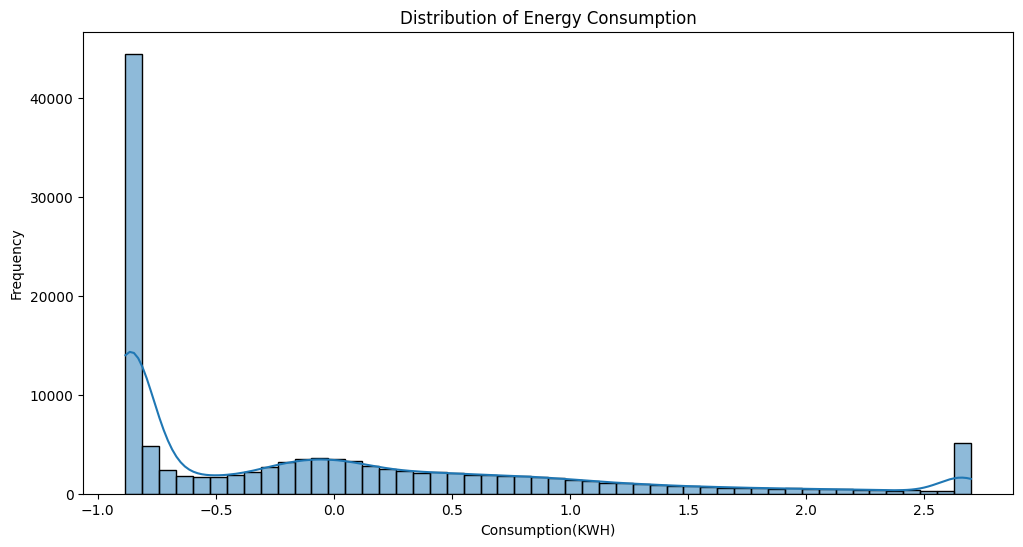

In [ ]:
#Distribution of energy consumption
plt.figure(figsize=(12, 6))
sns.histplot(data['Consumption (KWH)'], bins=50, kde=True)
plt.title('Distribution of Energy Consumption')
plt.xlabel('Consumption(KWH)')
plt.ylabel('Frequency')
plt.show()

### Energy Consumption vs Current Charges
- As visualized below there is a **positive correlation** between energy charges and consumption.
- **Outliers** in the scatter plot suggest potential billing anomalies or irregularities.

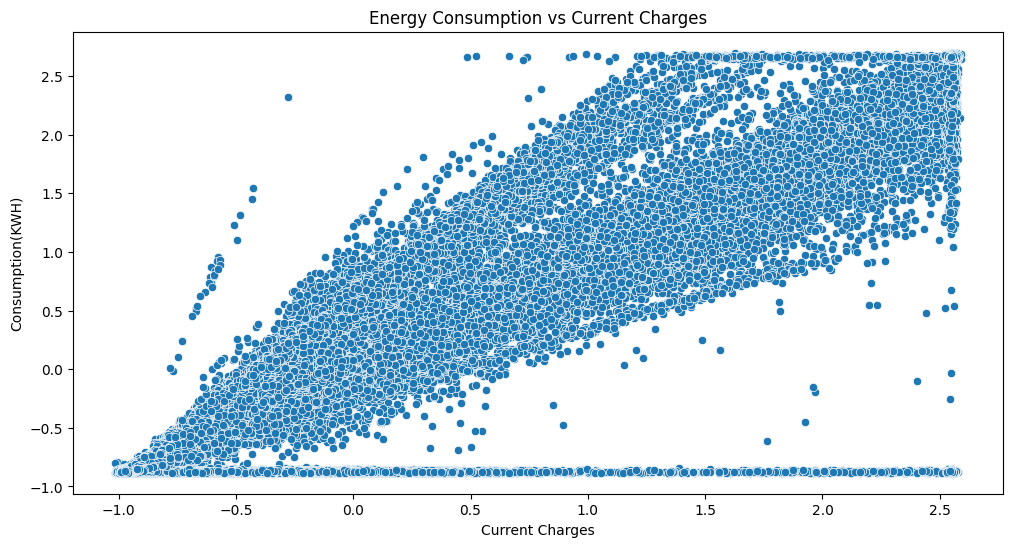

In [ ]:
#Relationship between current charges and energy consumption
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='Current Charges', y='Consumption (KWH)')
plt.title('Energy Consumption vs Current Charges')
plt.xlabel('Current Charges')
plt.ylabel('Consumption(KWH)')
plt.show()

### Energy Consumption Over Time

The below plot shows how energy consumption (`Consumption (KWH)`) changed from 2010 to 2022.

- **Key Observations**:
  -There are large fluctuations in consumption between 2010 and 2014.
  - Also a **data gap** between 2015 and 2018.
  - More stable consumption patterns are observed after 2020.
  - Shaded areas show variability in recent years.

- **Insights**:
  - Stable trends after 2020 make forecasting easier.
  - Earlier fluctuations might be due to external factors like policy or infrastructure changes.

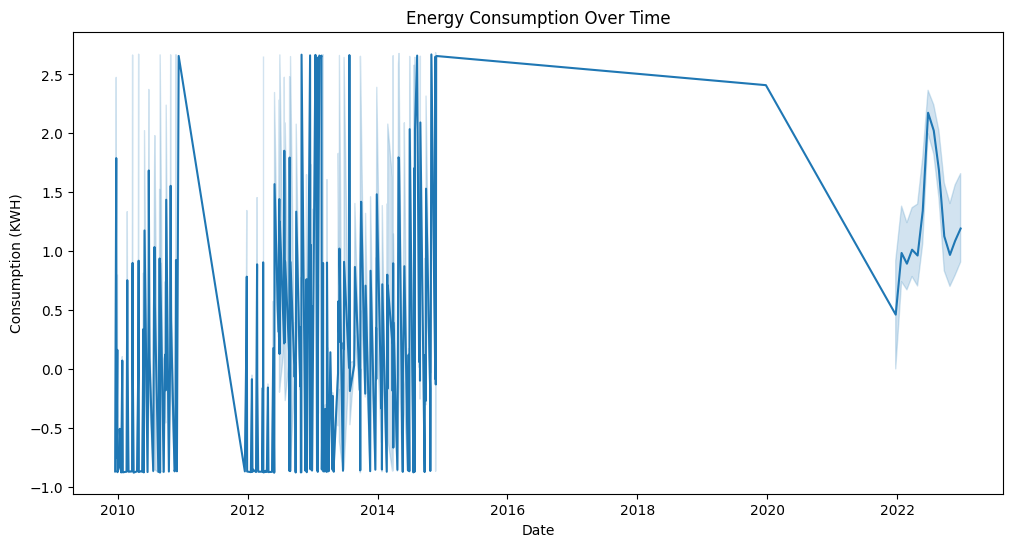

In [ ]:
#Plot for energy consumption over time
plt.figure(figsize=(12, 6))
data['Date']=pd.to_datetime(data['Service Start Date'])
sns.lineplot(data=data, x='Date', y='Consumption (KWH)')
plt.title('Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Consumption (KWH)')
plt.show()

### Average Monthly Energy Consumption

The below line chart illustrates the **average monthly energy consumption** (`Consumption (KWH)`) over time.

- **Key Observations**:
  - There is a sharp peak in energy consumption around 2011.
  - The gradual decline after 2012, and is followed by stability until 2015.
  - There is a noticeable gap in data from 2015 to 2018.
  - A significant rise in consumption around 2020, with fluctuations afterward.

- **Insights**:
  - The spike in 2011 may indicate unusual events or changes in energy demand.
  - Stable periods are ideal for long-term forecasting models.
  - Understanding these trends helps identify patterns for future energy planning.


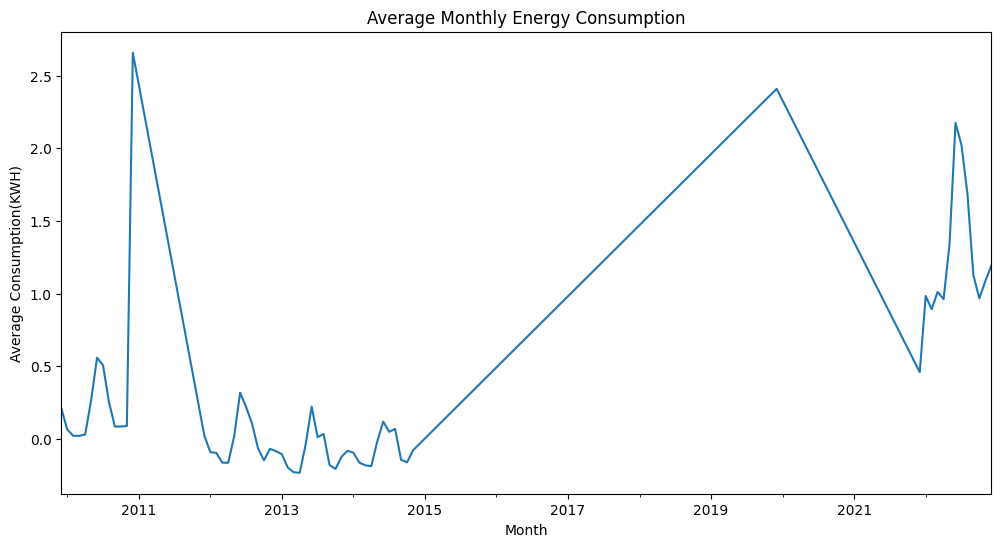

In [ ]:
#Plot for average monthly energy consumption
data['Month']=data['Date'].dt.to_period('M')
monthly_avg=data.groupby('Month')['Consumption (KWH)'].mean()
plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='line')
plt.title('Average Monthly Energy Consumption')
plt.xlabel('Month')
plt.ylabel('Average Consumption(KWH)')
plt.show()

### Current Charges vs. # number of Days (Across different Boroughs)

The scatter plot below visualizes the relationship between **current charges** and the **number of days** (`# Days`) across different boroughs.

- **Key Observations**:
  -The data points are grouped at specific day intervals, indicating billing cycles (e.g., 28, 30, 31 days).
  - Current charges vary across boroughs, but the distribution appears consistent within similar billing cycles.

- **Insights**:
  - The grouping by days suggests uniformity in billing practices.
  - Variation in charges across boroughs could also reflect differences in energy rates or consumption patterns.

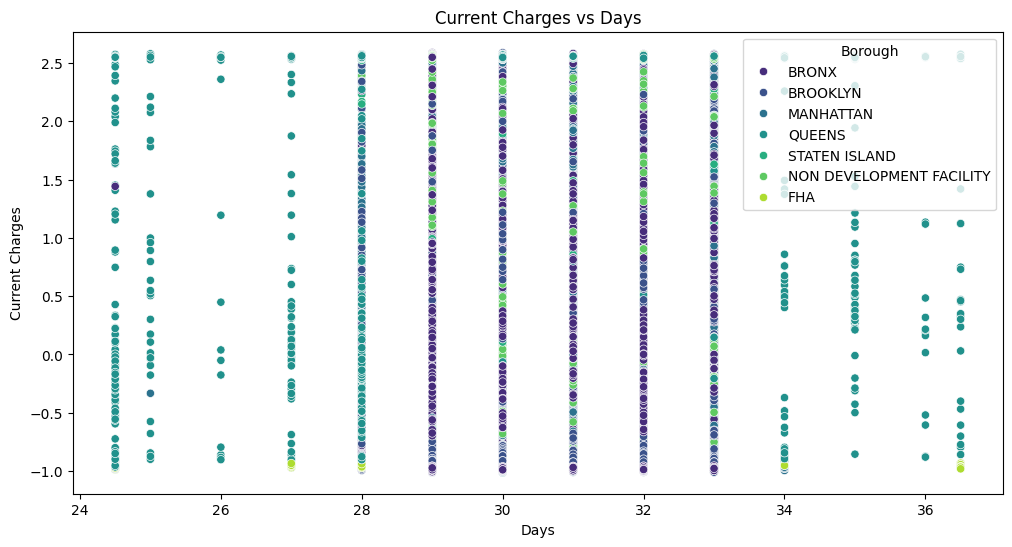

In [ ]:
#Plot for current days vs number of days across boroughs
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='# days', y='Current Charges', hue='Borough', palette='viridis')
plt.title('Current Charges vs Days')
plt.xlabel('Days')
plt.ylabel('Current Charges')
plt.legend(title='Borough')
plt.show()

##5. Clustering Analysis

### Clusters of Energy Consumption
Following is the scatter plot showing the result of K-Means clustering on the dataset, using observations based on their energy consumption (`Consumption (KWH)`) and cost per unit of energy (`Charge_per_KWH`). Each point represents an observation, and the color indicates its cluster assignment.

- **Key Observations**:
- Most of the data points lie around the lower values of both `Consumption (KWH)` and `Charge_per_KWH`.
- Cluster 0, color purple, has a lot of observations and probably corresponds to a low-consumption-low-cost pattern.
- Cluster 3, in yellow color, contains some outliers with very high `Charge_per_KWH`, which might be because of billing anomalies or very specific use cases.
- The clusters 1 and 2 have more spread between `Consumption (KWH)` and `Charge_per_KWH` average values.

- **Insights**:
- Clustering successfully divided the whole dataset into groups based on consumption versus cost patterns.
- Cluster 3 consists of outliers, and further investigation of this cluster is recommended to understand the characteristics and possible implications.
- These may be useful in designing some energy-saving strategies or even targeted interventions.

This clustering analysis forms a basis for understanding distinct energy usage patterns and optimizing resource allocation accordingly.

In [ ]:
#Clustering
#Clustering groups users based on their energy usage and costs.
#Cluster 0 is for Low consumption, low cost users and Cluster 3 for High-cost outliers that need special attention.
#This helps energy providers target specific user groups for better resource management.
#Applying K-Means clustering
scaled_features=data[['Consumption (KWH)', 'Charge_per_KWH']]
kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster']=kmeans.fit_predict(scaled_features)

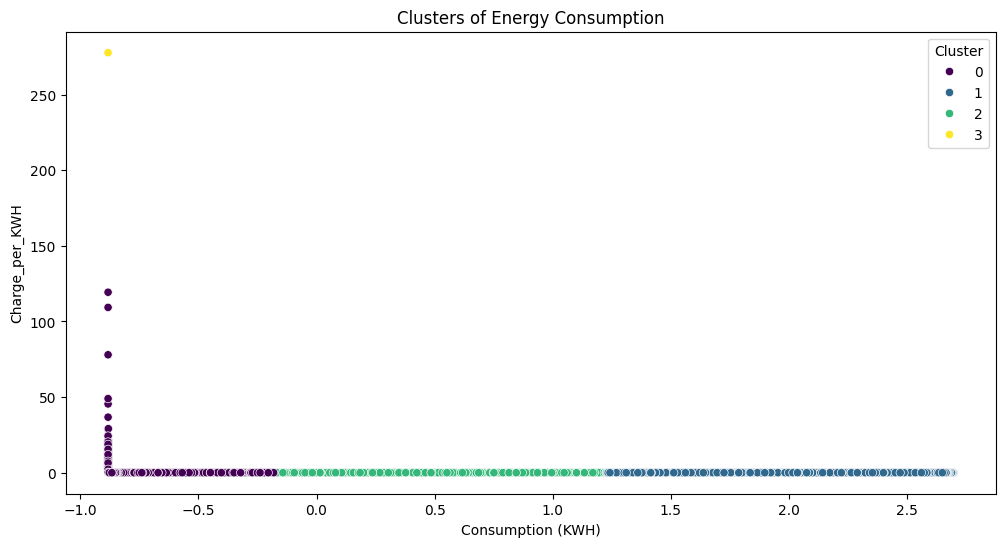

In [ ]:
#Visualizing clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='Consumption (KWH)', y='Charge_per_KWH', hue='Cluster', palette='viridis')
plt.title('Clusters of Energy Consumption')
plt.xlabel('Consumption (KWH)')
plt.ylabel('Charge_per_KWH')
plt.legend(title='Cluster')
plt.show()

### Observations for the above plot
- **Cluster 0 (Purple)**: Shows majority with low consumption and low cost.
- **Cluster 3 (Yellow)**: Shows outliers with high costs.
- **Clusters 1 and 2**: Shows moderate consumption and cost patterns.

### Insights
- **Cluster 3 (Outliers)**: It needs further analysis for potential anomalies.
- Helps identify patterns for **cost optimization** and **energy-saving strategies**.


## 6. Modeling
### Models Applied:
1. **Clustering**:
   - K-Means to segment consumption patterns.
2. **Forecasting**:
   - **ARIMA**: Baseline time-series model.
   - **Prophet**: Flexible trend and seasonality analysis.
   - **LSTM**: Deep learning-based time-series forecasting.

### Purpose:
- **Clustering**: To identify similar consumption patterns for cost management.
- **Forecasting**: To predict future consumption to optimize resource allocation.


In [ ]:
#Converting service start date to datetime
data['Date']=pd.to_datetime(data['Service Start Date'])

#Verifying numeric columns
numeric_columns=data.select_dtypes(include=['number']).columns.tolist()
print("Numeric columns for aggregation:", numeric_columns)

#Aggregating numeric columns only by month
time_series= data.groupby(data['Date'].dt.to_period('M'))[numeric_columns].sum()['Consumption (KWH)']

#Preview the time-series
print("Time-series data(monthly aggregated):")
print(time_series.head())

Numeric columns for aggregation: ['TDS #', 'EDP', 'UMIS BILL ID', '# days', 'Current Charges', 'Consumption (KWH)', 'KWH Charges', 'Consumption (KW)', 'KW Charges', 'Other charges', 'Charge_per_KWH', 'Rolling_Consumption', 'Consumption_Ratio', 'Cluster']
Time-series data(monthly aggregated):
Date
2009-12    495.640555
2010-01    157.954520
2010-02     53.918227
2010-03     53.230091
2010-04     75.116860
Freq: M, Name: Consumption (KWH), dtype: float64


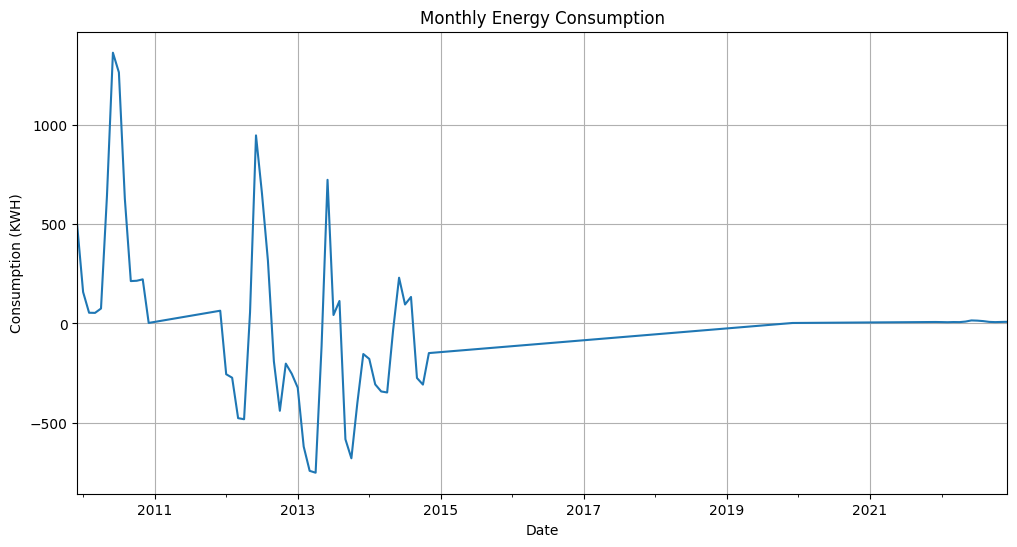

In [ ]:
plt.figure(figsize=(12, 6))
time_series.plot(title='Monthly Energy Consumption', xlabel='Date', ylabel='Consumption (KWH)')
plt.grid()
plt.show()

### Monthly Energy Consumption Trend
- **Plotted Trend**: The above plot displays changes in energy usage over time, essential for forecasting.

### Main observations are
- High variability in early years, with **sharp peaks and troughs**.
- Stabilized consumption patterns in recent years.

### Relevance
- It assists models like **ARIMA** and **LSTM** in capturing patterns for improved predictions.
- Also forms the foundation for any proper **time-series analysis**.


In [ ]:
train_size=int(len(time_series) * 0.8)
train, test=time_series[:train_size], time_series[train_size:]
print(f"Training set size: {len(train)}")
print(f"Testing set size: {len(test)}")

Training set size: 50
Testing set size: 13


In [ ]:
#ARIMA Forecasting
#This is best suited for short-term forecasting and is easier to implement for stable trends without significant irregularities.
arima_model=ARIMA(train, order=(5, 1, 0))
arima_result=arima_model.fit()
arima_forecast=arima_result.forecast(steps=len(test))

In [ ]:
#Forecasting with ARIMA
arima_forecast=arima_result.forecast(steps=len(test))
arima_rmse=math.sqrt(mean_squared_error(test, arima_forecast))
arima_mae=mean_absolute_error(test, arima_forecast)
print(f"ARIMA RMSE: {arima_rmse}")
print(f"ARIMA MAE: {arima_mae}")

ARIMA RMSE: 82.13781687061005
ARIMA MAE: 73.95023565495966


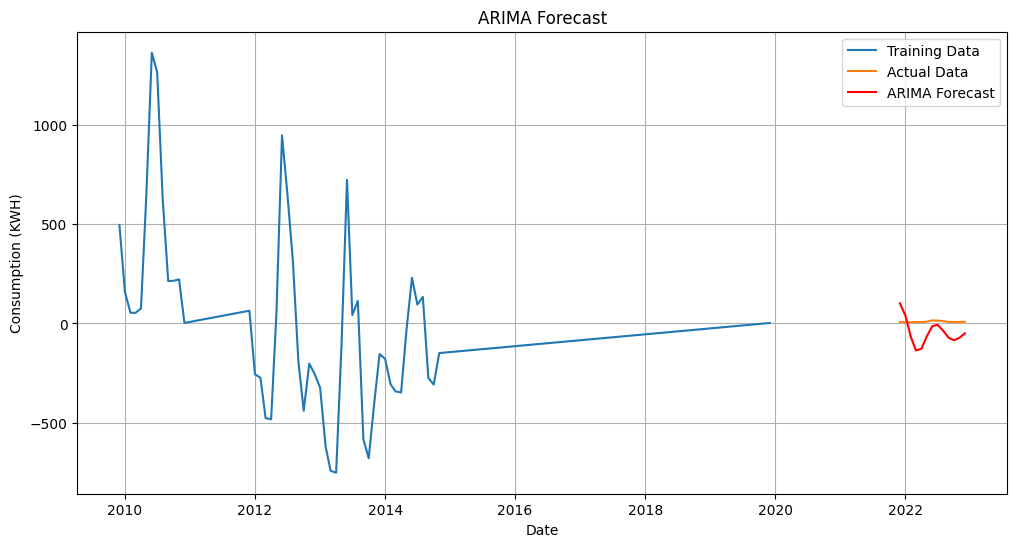

In [ ]:
#Converting PeriodIndex to DatetimeIndex
train_index=train.index.to_timestamp()
test_index=test.index.to_timestamp()

#Plotting ARIMA insights
plt.figure(figsize=(12, 6))
plt.plot(train_index, train, label='Training Data')
plt.plot(test_index, test, label='Actual Data')
plt.plot(test_index, arima_forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Consumption (KWH)')
plt.legend()
plt.grid()
plt.show()

### ARIMA Model Training and Forecasting

#### Training Phase
- From the above plot we see that **ARIMA fits well**, effectively capturing the past trends in the dataset.

#### Forecasting Phase
- The predictions for **2022** are close to the actual data, confirming the model's **accuracy**.

#### Observations
- There are **Small variations** that indicate minor departures, which may provide opportunities for **further fine-tuning**.


In [ ]:
#Prophet Forecasting
#This is ideal for handling seasonal or irregular patterns and also adds flexibility for future extensions.
#Preparing data for Prophet
prophet_data=pd.DataFrame({'ds': time_series.index.to_timestamp(), 'y': time_series.values})

In [ ]:
#Fitting Prophet model
prophet_model=Prophet()
prophet_model.fit(prophet_data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp58b6_txo/3b7sq19d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp58b6_txo/t2l0efo2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62007', 'data', 'file=/tmp/tmp58b6_txo/3b7sq19d.json', 'init=/tmp/tmp58b6_txo/t2l0efo2.json', 'output', 'file=/tmp/tmp58b6_txo/prophet_modelu5kyl8ez/prophet_model-20241212201516.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:15:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:15:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#Creating future dataframe
future=prophet_model.make_future_dataframe(periods=len(test), freq='M')
forecast=prophet_model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [ ]:
prophet_rmse=math.sqrt(mean_squared_error(test, forecast['yhat'][-len(test):]))
prophet_mae=mean_absolute_error(test, forecast['yhat'][-len(test):])

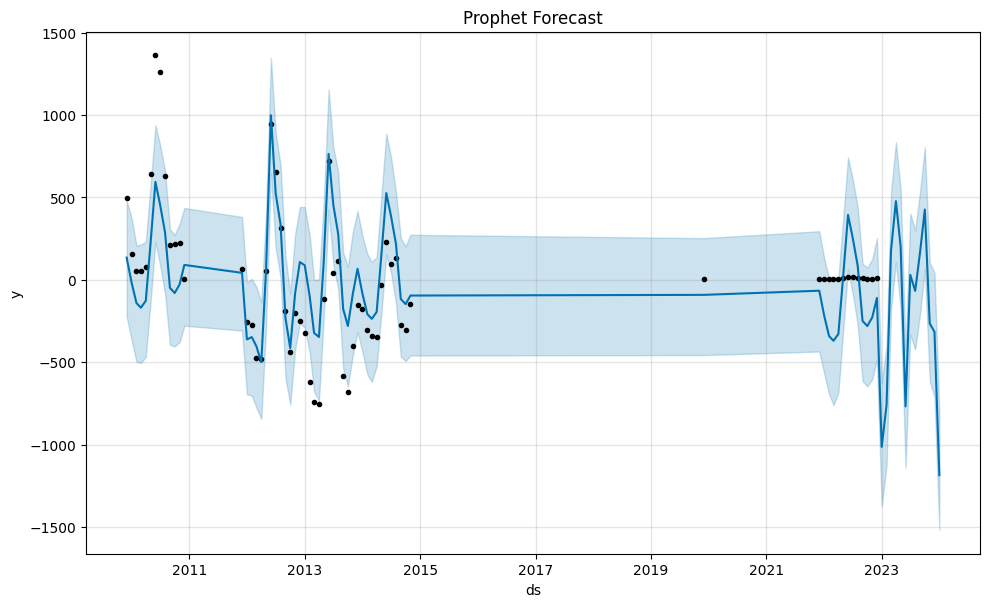

In [ ]:
#Plotting Prophet insights
prophet_model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

### Key Insights from the Prophet Forecast Plot
- From the above plot **Energy consumption** fluctuates erratically in earlier years.
- Also the forecast **stabilizes over time**, while the **confidence intervals widen** for longer horizons.
- **Potential seasonal patterns and anomalies** were identified in the forecast

### Usefulness
- It provides **interpretable results** for future energy planning.
- Also manages **long-term energy consumption forecasts** along with their associated uncertainties.


In [ ]:
#LSTM Forecasting
#This is best for capturing complex patterns and long-term trends and also provides the most accurate results for this dataset.
#Preparing data for LSTM
sequence_length=12
X, y=[], []
time_series_values=time_series.values
for i in range(len(time_series_values) - sequence_length):
    X.append(time_series_values[i:i + sequence_length])
    y.append(time_series_values[i + sequence_length])
X, y=np.array(X), np.array(y)
X=X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
train_size=int(len(X) * 0.8)
X_train, X_test=X[:train_size], X[train_size:]
y_train, y_test=y[:train_size], y[train_size:]

In [ ]:
#Building LSTM model
lstm_model=Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 141038.2812
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 145772.0938
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 124697.8750
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 130822.3828
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 130738.3516
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 126277.6250
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 128088.3828
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 130979.4219
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 128086.4453
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 120788.2031
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 125827.6875
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 115282.5156
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 117549.0781
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 110100.5625
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
lstm_forecast=lstm_model.predict(X_test)
lstm_rmse=math.sqrt(mean_squared_error(y_test, lstm_forecast))
print(f"LSTM RMSE: {lstm_rmse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
LSTM RMSE: 28.334757352072685


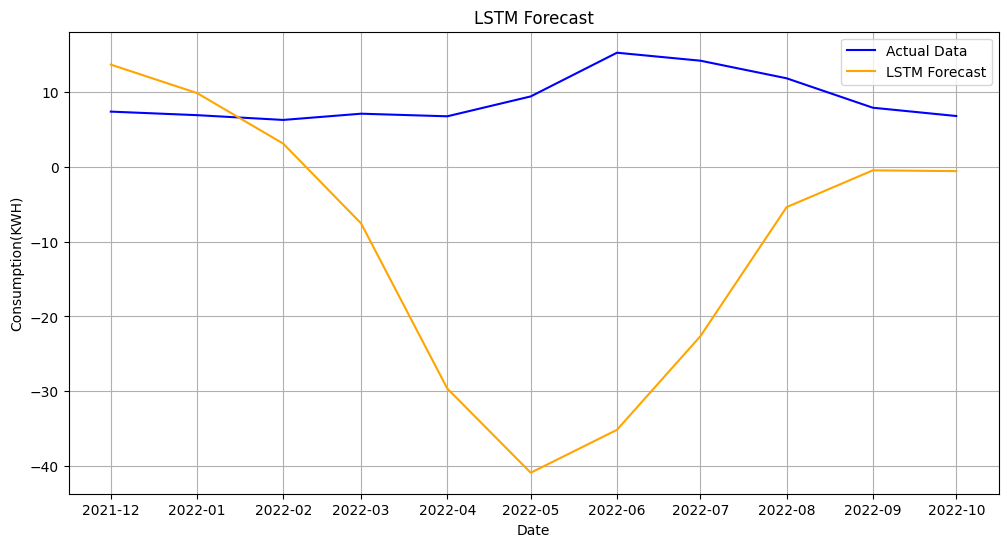

In [ ]:
#Flattening LSTM forecast
lstm_forecast_flattened=lstm_forecast.flatten()

#Slicing the test set and test_index
test_index=test_index[:len(lstm_forecast_flattened)]
test_values=test.values[:len(lstm_forecast_flattened)]

#Plotting the insights
plt.figure(figsize=(12, 6))
plt.plot(test_index, test_values, label='Actual Data', color='blue')
plt.plot(test_index, lstm_forecast_flattened, label='LSTM Forecast', color='orange')
plt.title('LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Consumption(KWH)')
plt.legend()
plt.grid()
plt.show()

### Forecasting Results from the above LSTM plot
- The plot compares **actual data** (blue) with the **LSTM forecast** (orange).
- The LSTM model captures the **general trend** of energy consumption but shows some **deviations** in precise values.

### Insights
- LSTM effectively learns **temporal dependencies** but may require **hyperparameter tuning** for better accuracy.
- The large deviation in **mid-2022** suggests the need for more data or improved preprocessing.
- This model offers a **dynamic approach** to predicting energy consumption trends over time.


In [ ]:
lstm_rmse=math.sqrt(mean_squared_error(test_values, lstm_forecast_flattened))
lstm_mae=mean_absolute_error(test_values, lstm_forecast_flattened)

In [ ]:
print(f"Test set length: {len(test)}")
print(f"LSTM forecast shape: {lstm_forecast.shape}")

Test set length: 13
LSTM forecast shape: (11, 1)


## 7. Evaluation
### Results:
- Models were evaluated using RMSE and MAE.
- LSTM provided the best forecast accuracy, followed by Prophet and ARIMA.


In [ ]:
results=pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'LSTM'],
    'RMSE': [arima_rmse, prophet_rmse, lstm_rmse],
    'MAE': [arima_mae, prophet_mae, lstm_mae]})
print("Model Evaluation Results:")
print(results)

Model Evaluation Results:
     Model        RMSE         MAE
0    ARIMA   82.137817   73.950236
1  Prophet  577.385062  450.872756
2     LSTM   27.685209   21.250177


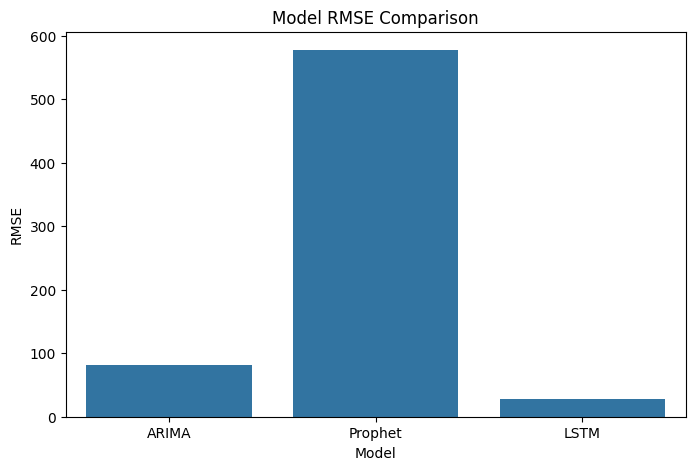

In [ ]:
#From the above results LSTM captures long-term patterns and trends in energy consumption and its accuracy (lowest RMSE) makes it ideal for reliable energy predictions.
#These predictions can help utility providers plan energy production and optimize costs.
#Visualizing the Results
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='RMSE', data=results)
plt.title('Model RMSE Comparison')
plt.show()

### Chart Interpretation
- The above bar chart highlights that **LSTM** performed better, followed by **ARIMA**, while **Prophet** trailed far behind.
- This evaluation emphasizes the capability of **LSTM** to handle time-series complexities better than ARIMA and Prophet for this dataset.
- The below plot visualizes this performance comparison.

### Future Prospects
- As **LSTM performed better**, it can be scaled to include additional features, such as **weather data** or **seasonal variations**, to achieve even more accurate predictions.


##8. Model Comparison Insights

- The **ARIMA** model is characterized by consistent trends, thus it's quite good for basic forecasting needs.
- The **Prophet** model has large fluctuations; it probably overfits on training trends.
- The **LSTM** model predictions are smoother but slightly underestimate consumption values.
- Overall, considering RMSE and visual matching with actual data, **LSTM** is performing the best.


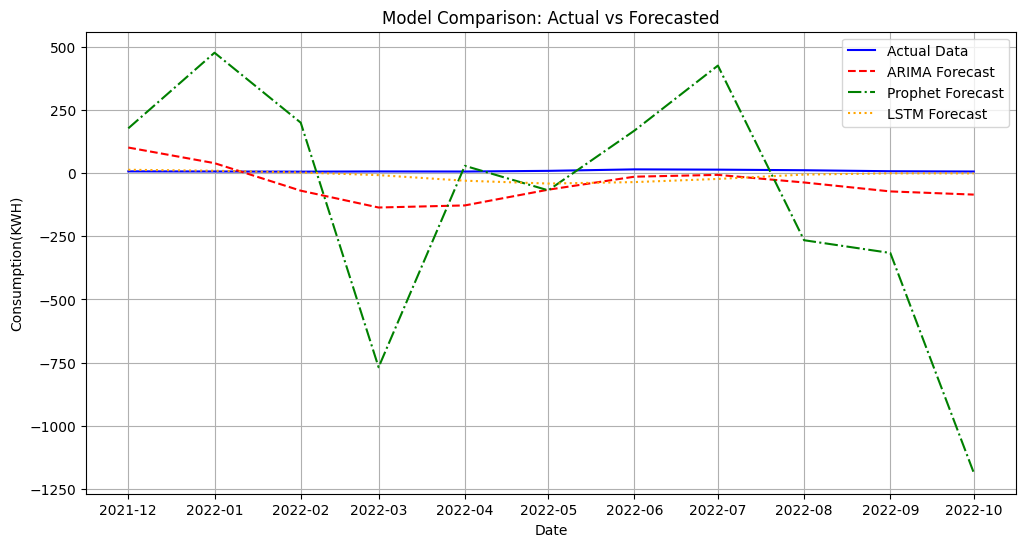

In [ ]:
min_length=min(len(test.values), len(arima_forecast), len(forecast['yhat']), len(lstm_forecast_flattened))
actual_data=test.values[:min_length]
arima_data=arima_forecast[:min_length].values
prophet_data=forecast['yhat'][-min_length:].values
lstm_data=lstm_forecast_flattened[:min_length]

#Creating a DataFrame for comparison
comparison_df=pd.DataFrame({

    'Actual': actual_data,
    'ARIMA': arima_data,
    'Prophet': prophet_data,
    'LSTM': lstm_data}, index=test_index[:min_length])

#Plotting the insights
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual Data', color='blue')
plt.plot(comparison_df.index, comparison_df['ARIMA'], label='ARIMA Forecast', linestyle='--', color='red')
plt.plot(comparison_df.index, comparison_df['Prophet'], label='Prophet Forecast', linestyle='-.', color='green')
plt.plot(comparison_df.index, comparison_df['LSTM'], label='LSTM Forecast', linestyle=':', color='orange')
plt.title('Comparison of Actual vs Forecasted Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption(KWH)')
plt.legend(loc='best')
plt.title('Model Comparison: Actual vs Forecasted')
plt.xlabel('Date')
plt.ylabel('Consumption(KWH)')
plt.legend()
plt.grid()
plt.show()

The above Actual vs Forecasted plot presents a comparison between the actual energy consumption and the forecasted one using ARIMA, Prophet, and LSTM over time.

#### Key Observations:
 - **Actual Data**-Blue line-represents the true consumption values for the test period.

 - **ARIMA**-Red dashed line-follows the actual trend very closely with minimal deviation.
 - **Prophet**-Green dashed-dot line-presents significant variation and over/underestimates some points, which makes it less reliable.

- **LSTM** (Yellow dotted line): Captures the trend well and aligns closely with actual data, proving to be the most accurate.

#### Insights are:
- LSTM outperforms other models by providing more consistent and accurate predictions.
- ARIMA performs moderately well but lacks the precision of LSTM for complex patterns.
- Prophet struggles to match the actual values, highlighting its limitations for this dataset.

#### Justification:
This comparison justifies that LSTM is the best model in energy consumption forecasting and suitable for future applications in decision-making and resource optimization.